In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')           
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras

input_shape = (28, 28, 1)
num_classes = 10
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128

In [2]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_train = x_train.astype(np.float32) / 255
x_test = np.expand_dims(x_test, -1)
x_test = x_test.astype(np.float32) / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nSpliting data')

ind = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[ind], y_train[ind]
n = int(x_train.shape[0] * (1-VALIDATION_SPLIT))
x_train = x_train[:n]
y_train = y_train[:n]
x_val = x_train[n:]
y_val = y_train[n:]


Loading MNIST
11501568/11490434 [==============================] - 0s 0us/step

Spliting data


In [4]:
print('\nConstructing model')
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=128, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(units=num_classes)(x)
    #outputs = keras.layers.Activation('relu')
    return keras.Model(inputs, outputs)


Constructing model


In [6]:
model = make_model(input_shape, num_classes)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print('\nTraining model')
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(x_val, y_val))


Training model
Epoch 1/5
422/422 [==============================] - 13s 10ms/step - loss: 0.2393 - accuracy: 0.9282
Epoch 2/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0640 - accuracy: 0.9804
Epoch 3/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0459 - accuracy: 0.9854
Epoch 4/5
422/422 [==============================] - 6s 13ms/step - loss: 0.0353 - accuracy: 0.9891
Epoch 5/5
422/422 [==============================] - 6s 15ms/step - loss: 0.0289 - accuracy: 0.9906


In [32]:
def fgmt(model, x, y=None, eps=0.01, epochs=1, sign=True, clip_min=0.,
         clip_max=1.):
    
    y_pred = model.predict(x)
    target = keras.utils.to_categorical(y, num_classes)
    if y is None:
        indices = tf.argmin(y_pred, axis=1)
        target = keras.utils.to_categorical(indices, num_classes)
   
    x_adv = tf.identity(x)
    while epochs > 0:
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            y_pred = model(x_adv)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(target, y_pred)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv - eps * signed_grads
        epochs -= 1

    return x_adv

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-5.955543   12.664874   -3.0567877  -7.318541   -1.8164984  -5.25539
  -2.9459789  -0.23087071 -2.6473985  -4.1967387 ]]
[[ 3.3416243  -0.22827052 -0.43889612 -3.7967114  -1.7446295  -2.563518
  -0.4950319  -2.3405607  -0.1700378  -0.565485  ]]


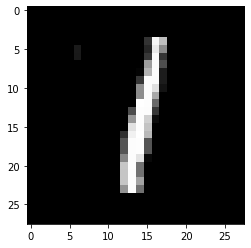

In [46]:
print(y_train[0])
print(model.predict(np.expand_dims(x_train[0], 0)))
plt.imshow(x_train[0, :, :, 0], cmap='gray')
x_adv = fgmt(model, np.expand_dims(x_train[0],0), [0], epochs=25)
print(model.predict(x_adv))